In [1]:
import torch
import yolov5.utils
display = yolov5.utils.notebook_init()  # checks
import matplotlib.pyplot as plt
import cv2
import rospy

%matplotlib inline
# important to start the node
rospy.init_node('yolo_test_node')


YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)


Setup complete ✅ (16 CPUs, 14.8 GB RAM, 193.5/245.0 GB disk)


In [2]:
import ros_numpy
import numpy as np
from sensor_msgs.msg import Image , LaserScan , PointCloud2
class RGBD():
    def __init__(self):
        
        self._cloud_sub = rospy.Subscriber(
            "/camera/depth_registered/points",
            PointCloud2, self._cloud_cb)
        self._points_data = None
        self._image_data = None
        

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)
        self._image_data = self._points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
        

    def get_image(self):
        return self._image_data

    def get_points(self):
        return self._points_data

In [3]:
rgbd = RGBD()


<class 'numpy.ndarray'>


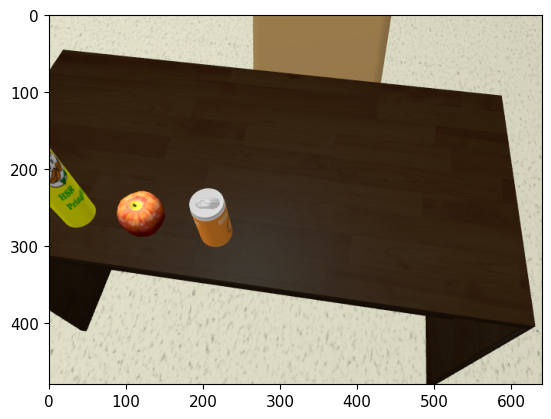

In [4]:
test_img = rgbd.get_image()
print(type(test_img))
plt.imshow(test_img)

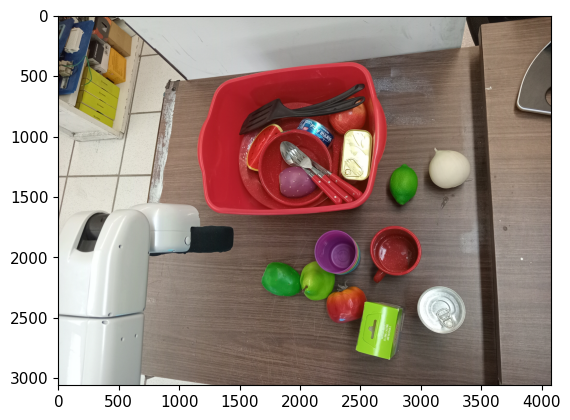

In [5]:
import rospkg
import os
import matplotlib.image as mpimg

rpg = rospkg.RosPack()
package_path = rpg.get_path('vision_modules')
img_path = os.path.join(package_path, "scripts")

img = mpimg.imread(img_path + '/20240223_171508.jpg')
plt.imshow(img)

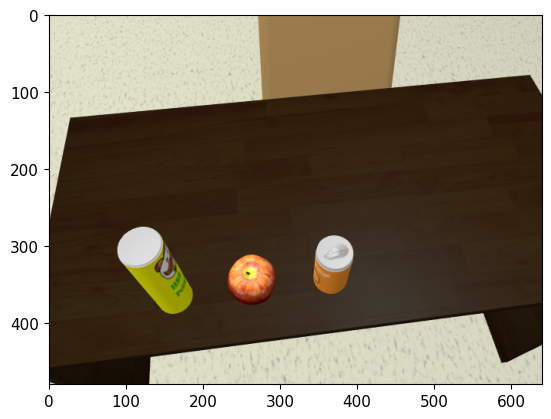

In [6]:
def save_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("simulation.png", img)


def load_image():
    test_img = cv2.imread(img_path + '/simulation.png')
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    return test_img


test_img = cv2.imread(img_path + '/simulation.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

#save_image(test_img)

In [7]:
from yolov5.models.experimental import attempt_load
from yolov5.utils.general import *
from yolov5.utils.torch_utils import select_device

from cv_bridge import CvBridge
from object_classification.srv import Classify,ClassifyResponse, ClassifyRequest
import torch

device = select_device('')
file_path = rpg.get_path('object_classification')
ycb_yolo_path=file_path+'/src/weights/ycb.pt'
print(ycb_yolo_path)
model=attempt_load(ycb_yolo_path,device)

YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)



/home/devan/GIT/Juskeshino/catkin_ws/src/vision/object_classification/src/weights/ycb.pt


Fusing layers... 
Model summary: 369 layers, 21138024 parameters, 0 gradients, 49.1 GFLOPs


(480, 640, 3)
<class 'numpy.ndarray'>
[tensor([[8.89629e+01, 2.75735e+02, 1.86854e+02, 3.87913e+02, 8.94575e-01, 1.00000e+00],
        [2.32562e+02, 3.12353e+02, 2.91797e+02, 3.77086e+02, 8.13304e-01, 1.20000e+01],
        [3.43171e+02, 2.87233e+02, 3.94870e+02, 3.61917e+02, 7.88524e-01, 2.10000e+01],
        [3.43229e+02, 2.87216e+02, 3.94670e+02, 3.61907e+02, 6.69061e-01, 1.00000e+00],
        [2.32481e+02, 3.12378e+02, 2.92829e+02, 3.75971e+02, 5.45459e-01, 1.60000e+01],
        [8.90585e+01, 2.75103e+02, 1.87226e+02, 3.86643e+02, 2.87153e-01, 5.00000e+00]], device='cuda:0')]
torch.Size([6, 6])


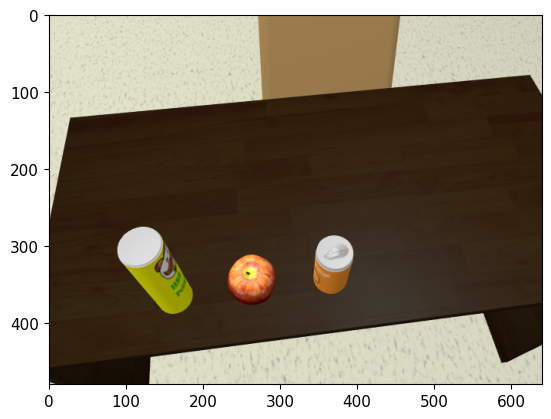

In [8]:
sampling_img = test_img
print(sampling_img.shape)
sample = torch.from_numpy(sampling_img).to(device)
sample = sample / 255.0
sample = sample.unsqueeze(0)
sample = torch.moveaxis(sample, 3, 1)
pred = model(sample, augment=False)[0]

plt.imshow(sampling_img)
print(type(sampling_img))

detections = non_max_suppression(pred)  # IOU 
print(detections)
print(detections[0].shape)

In [13]:
def calc_IOU(boxA, boxB):
	xA = max(boxA[0][0], boxB[0][0])
	yA = max(boxA[0][1], boxB[0][1])
	xB = min(boxA[1][0], boxB[1][0])
	yB = min(boxA[1][1], boxB[1][1])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[1][0] - boxA[0][0] + 1) * (boxA[1][1] - boxA[0][1] + 1)
	boxBArea = (boxB[1][0] - boxB[0][0] + 1) * (boxB[1][1] - boxB[0][1] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou


def plot_labels(points, labels, sampling_img):
    debug_img = sampling_img.copy()
    for (point, label) in zip(points, labels):
        print(label)
        debug_img = cv2.rectangle(debug_img, point[0] , point[1],  (0, 255, 0), 2)
        debug_img = cv2.putText(debug_img, label[1], (point[0][0]-10, point[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        print(point[0], point[1], label[0], label[1])
        print()
    plt.imshow(debug_img)


def get_notations(detections, confidence_threshold = 0.4, rem_overlaps=False):
    points = []
    labels = []
    for detect in detections:
        for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
            if conf.cpu().tolist() > confidence_threshold:
                pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
                pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

                points.append((pt_min, pt_max))
                labels.append([round(conf.cpu().tolist(), 3), model.names[int(cls.cpu().tolist())]])     

    print(labels)
    print(points)
    if rem_overlaps:
        for i, (point, label) in enumerate(zip(points, labels)):
            for j, (p, l) in enumerate(zip(points, labels)):
                if i != j:
                    iou = calc_IOU(point, p)
                    if iou > 0.9:
                        points.pop(j)
                        labels.pop(j)
    
    print(labels)
    print(points)
    return points, labels
 

[[0.895, '002_master_chef_can'], [0.813, '013_apple'], [0.789, '021_bleach_cleanser'], [0.669, '002_master_chef_can'], [0.545, '017_orange']]
[((88, 275), (186, 387)), ((232, 312), (291, 377)), ((343, 287), (394, 361)), ((343, 287), (394, 361)), ((232, 312), (292, 375))]
[[0.895, '002_master_chef_can'], [0.813, '013_apple'], [0.789, '021_bleach_cleanser']]
[((88, 275), (186, 387)), ((232, 312), (291, 377)), ((343, 287), (394, 361))]

[0.895, '002_master_chef_can']
(88, 275) (186, 387) 0.895 002_master_chef_can

[0.813, '013_apple']
(232, 312) (291, 377) 0.813 013_apple

[0.789, '021_bleach_cleanser']
(343, 287) (394, 361) 0.789 021_bleach_cleanser



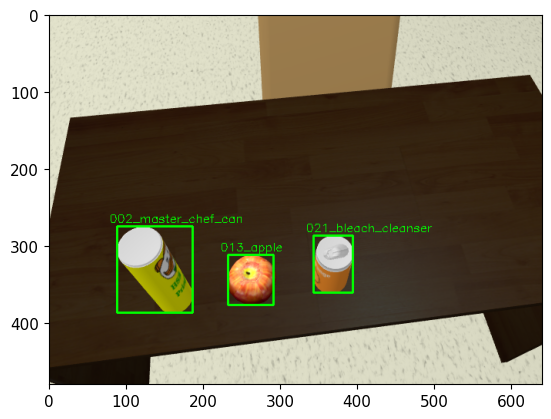

In [16]:
points, labels = get_notations(detections, rem_overlaps=True)
print()
plot_labels(points, labels, sampling_img)

# ----------------------------

In [ ]:
debug_img = sampling_img.copy()

num_preds = 0
points = []
confidence_threshold = 0.4

for detect in detections:
    for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
        if conf.cpu().tolist() > confidence_threshold:
            num_preds+=1
            pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
            pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

            points.append((pt_min, pt_max))

            debug_img = cv2.rectangle(debug_img ,pt_min,pt_max,  (0, 255, 0), 2)
            debug_img = cv2.putText(debug_img, model.names[int(cls.cpu().tolist())],
                        pt_min, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(num_preds, pt_min, pt_max, conf.cpu().tolist(), model.names[int(cls.cpu().tolist())] )
    
plt.imshow(debug_img)